In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn import (
    Module,
    Conv2d,
    BatchNorm2d,
    MaxPool2d,
    Dropout2d,
    Linear,
    BatchNorm1d,
    ReLU,
    Dropout,
    CrossEntropyLoss,
)
from torchsummary import summary
from torch.nn.modules.loss import BCEWithLogitsLoss

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics & Calibration
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    brier_score_loss,
    roc_auc_score,
)
from sklearn.calibration import calibration_curve
from matplotlib.gridspec import GridSpec



C:\Users\MI30743\AppData\Local\Temp\1\ipykernel_15004\753830450.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
IMGS_STRUCTURE_CSV = os.path.join(
    os.getcwd(),'data\\custom_data\\',
    "images_reorganization.csv"
    ) 

In [3]:
df_reorg = pd.read_csv(IMGS_STRUCTURE_CSV)

In [4]:
df_reorg

,images,group,label,folder_label
0,AE00409_170552_00_1_2_2001.jpg,train,1,2
1,AE00408_120515_00_3_4_2001.jpg,train,0,1
2,AE00227_212425_00_3_4_2001.jpg,train,1,2
3,AE00309_083542_00_2_1_2001.jpg,train,1,2
4,AE00305_112326_00_1_3_2001.jpg,train,1,2
...,...,...,...,...
10604,AE00227_033425_00_3_1_2001.jpg,test,1,2
10605,AE00531_061059_00_4_3_2001.jpg,test,1,2
10606,AE00343_085315_00_2_2_2001.jpg,test,1,2
10607,AE00305_144800_00_2_2_2001.jpg,test,1,2


In [5]:
df_reorg.query("group == 'train'").iloc[2,2]

1

In [6]:
BATCH_SIZE = 128
SIZE = (256, 256)

In [7]:
transforms = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]
)

In [8]:
class CustomDataset(Dataset):
    """
    Helper to read images from current folder structure defined using
    a csv file, indicating what image belong to each group (train, val, test)
    """
    
    def __init__(self, csv_file, group='train', transform=None) -> None:

        self.group = group
        self.df = pd.read_csv(csv_file).query(
            f"group == '{self.group}'"
            )
        self.transform = transform
        self.targets = self.df.label.to_list()
        self.class_to_idx = Counter(self.df.label.to_list())

    def __len__(self):
        return len(self.df)
    
    def load_image(self, index) -> Image.Image:
        
        image_name = os.path.join(
            os.getcwd(),'data\\custom_data\\',
            self.group,
            self.df.iloc[index, 0]
            )
        
        return Image.open(image_name)
    
    def __getitem__(self, index):
        image = self.load_image(index)
        label = int(self.df.iloc[index, 2])

        if self.transform:
            return self.transform(image), label
        else:
            return image, label
    

In [9]:
train_dataset = CustomDataset(csv_file=IMGS_STRUCTURE_CSV, group='train', transform=transforms)
val_dataset = CustomDataset(csv_file=IMGS_STRUCTURE_CSV, group='val', transform=transforms)
test_dataset = CustomDataset(csv_file=IMGS_STRUCTURE_CSV, group='test', transform=transforms)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
def show_images(num_samples, loader):
    # Initialize lists to hold sampled images and targets
    sampled_images = []
    sampled_targets = []

    # Sample up to num_samples images and targets from the DataLoader
    for images, targets in loader:
        for i in range(images.size(0)):
            sampled_images.append(images[i])
            sampled_targets.append(targets[i])
            if len(sampled_images) >= num_samples:
                break
        if len(sampled_images) >= num_samples:
            break

    # Determine the number of samples actually gathered
    actual_num_samples = len(sampled_images)

    # Setup for subplots based on the actual number of samples
    fig, axes = plt.subplots(
        nrows=1, ncols=actual_num_samples, figsize=(actual_num_samples * 2.5, 2.5)
    )
    if actual_num_samples == 1:
        axes = [axes]  # Making it iterable for consistency

    # Display the sampled images
    for idx, (img, target) in enumerate(zip(sampled_images, sampled_targets)):
        ax = axes[idx]
        img = img.squeeze()  # Assuming grayscale for simplicity
        ax.imshow(img.numpy(), cmap="gray")  # Convert to numpy and display
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Tag: {target.item()}")

    plt.tight_layout()
    plt.show()

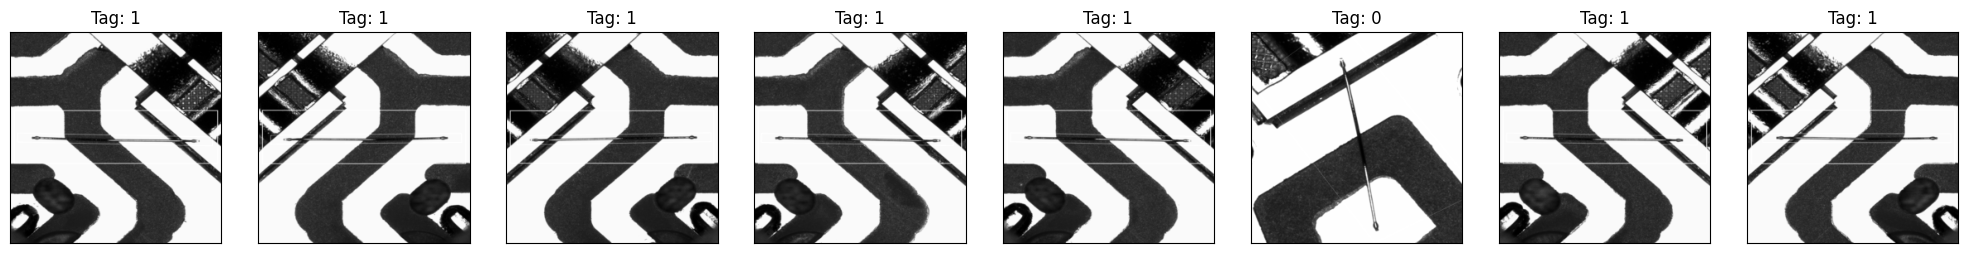

In [12]:
show_images(8, train_loader)

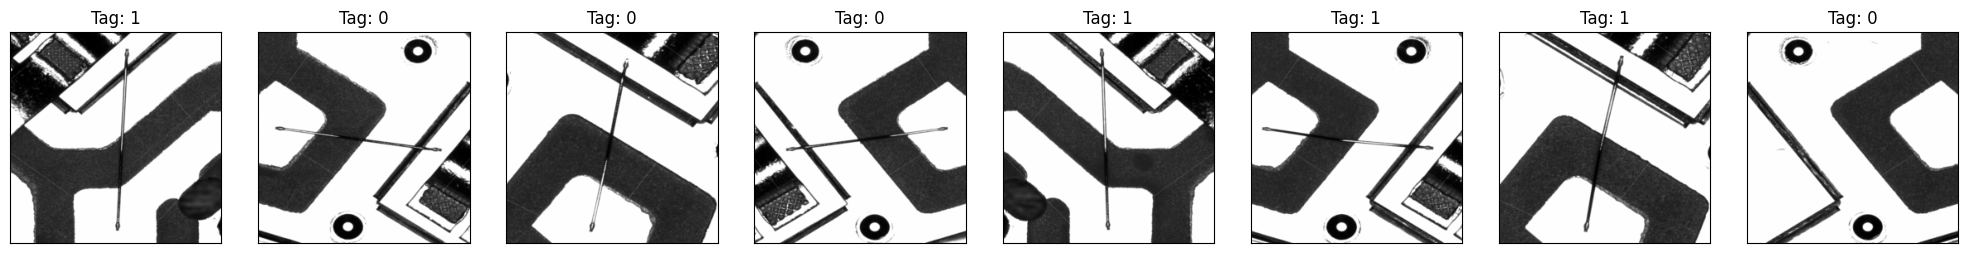

In [13]:
show_images(8, val_loader)

In [14]:
# Pytorch Neural Net
do = 0.3
input = 1
output = 32
kernel = 3
target = 2

In [15]:
class ImageClassifier(torch.nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.conv1 = Conv2d(input, output, kernel_size=kernel, padding=1, stride=1, bias=False)
        self.relu = ReLU(inplace=True)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(output, output*2, kernel_size=kernel, padding=1, stride=1, bias=False)
        self.fc1 = Linear(64*64*64, 256)
        self.fc2 = Linear(256, target)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = x.view(
            x.shape[0], -1
            )  # Flatten dimensions except batch size to enter to the linear layer
        
        x = self.fc1(x)
        x =  self.fc2(x)

        return x

In [16]:
# class ImageClassifier(Module):
#     def __init__(self):
#         super().__init__()
#         self.conv2D1 = Conv2d(input, output, kernel_size=kernel, padding=0, bias=False)
#         self.conv2D2 = Conv2d(
#             output, output * 2, kernel_size=kernel, padding=0, bias=False
#         )
#         self.conv2D3 = Conv2d(
#             output * 2, output * 4, kernel_size=kernel, padding=0, bias=False
#         )
#         self.conv2D4 = Conv2d(
#             output * 4, output * 8, kernel_size=kernel, padding=0, bias=False
#         )
#         self.conv2D5 = Conv2d(
#             output * 8, output * 16, kernel_size=kernel, padding=0, bias=False
#         )
#         self.bn2D1 = BatchNorm2d(output)
#         self.bn2D2 = BatchNorm2d(output * 2)
#         self.bn2D3 = BatchNorm2d(output * 4)
#         self.bn2D4 = BatchNorm2d(output * 8)
#         self.bn2D5 = BatchNorm2d(output * 16)
#         self.relu = ReLU()
#         self.maxpool = MaxPool2d(kernel_size=kernel - 1, stride=2)
#         self.dropout2D = Dropout2d(do/2)
#         self.dense1 = Linear(2048, output * 8)
#         self.dense2 = Linear(output * 8, output * 4)
#         self.bn1D1 = BatchNorm1d(output * 8)
#         self.bn1D2 = BatchNorm1d(output * 4)
#         self.dropout1D = Dropout(do)
#         self.dense3 = Linear(output * 4, target)

#     def forward(self, x):
#         x = self.dropout2D(self.maxpool(self.relu(self.bn2D1(self.conv2D1(x)))))
#         x = self.dropout2D(self.maxpool(self.relu(self.bn2D2(self.conv2D2(x)))))
#         x = self.dropout2D(self.maxpool(self.relu(self.bn2D3(self.conv2D3(x)))))
#         x = self.maxpool(self.relu(self.bn2D4(self.conv2D4(x))))
#         x = self.maxpool(self.relu(self.bn2D5(self.conv2D5(x))))
#         x = x.view(
#             x.shape[0], -1
#         )  # Flatten dimensions except batch size to enter to the linear layer
#         x = self.dropout1D(self.relu(self.bn1D1(self.dense1(x))))
#         x = self.relu(self.bn1D2(self.dense2(x)))
#         x = self.dense3(x)

#         return x

In [17]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

In [18]:
model = ImageClassifier()
model.to(device)

ImageClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Linear(in_features=262144, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [19]:
from torchsummary import summary

summary(model, (1, SIZE[0], SIZE[1]), batch_size=BATCH_SIZE, device="cuda")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 32, 256, 256]             288
              ReLU-2        [128, 32, 256, 256]               0
         MaxPool2d-3        [128, 32, 128, 128]               0
            Conv2d-4        [128, 64, 128, 128]          18,432
              ReLU-5        [128, 64, 128, 128]               0
         MaxPool2d-6          [128, 64, 64, 64]               0
            Linear-7                 [128, 256]      67,109,120
            Linear-8                   [128, 2]             514
Total params: 67,128,354
Trainable params: 67,128,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 32.00
Forward/backward pass size (MB): 6912.25
Params size (MB): 256.07
Estimated Total Size (MB): 7200.33
----------------------------------------------------------------


In [20]:
class EarlyStopping:
    def __init__(self, patience, verbose=False, delta=0, path="checkpoint.pt"):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(
                f"Validation Loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model to {self.path}"
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        """Loads the best model weights from the saved checkpoint."""
        model.load_state_dict(torch.load(self.path))

In [21]:
# Tunners
LR = 0.0001
EPOCHS = 10

In [22]:
print(f"Classes: {train_dataset.class_to_idx}")
num_classes_train = Counter(train_dataset.targets)
num_classes_val = Counter(val_dataset.targets)
print(f"Train Dataset: {num_classes_train}")
print(f"Val Dataset: {num_classes_val}")

Classes: Counter({1: 4212, 0: 2577})
Train Dataset: Counter({1: 4212, 0: 2577})
Val Dataset: Counter({1: 1053, 0: 645})


In [23]:
# Define class frequencies
class_frequencies = torch.tensor(
    [num_classes_train[0], num_classes_train[1]], dtype=torch.float32
)  # Example frequencies for two classes

# Calculate class weights
total_samples = class_frequencies.sum()
class_weights = total_samples / (class_frequencies * len(class_frequencies))
class_weights[0]=class_weights[0]*5
class_weights[1]=class_weights[1]/5

In [24]:
optimizer = optim.Adam(
    model.parameters(),
    lr=LR,
    amsgrad=True,
    weight_decay=LR * 0.1
    )

criterion = CrossEntropyLoss(weight=class_weights).to(device)
#criterion = BCEWithLogitsLoss(weight=class_weights).to(device)
early_stopping = EarlyStopping(patience=int(EPOCHS * 0.5), verbose=True)

In [25]:
def train_eval(model, loader, optimizer, loss_func, is_training):
    correct = 0
    loss_list = []
    stop = False
    model.train() if is_training else model.eval()

    with torch.set_grad_enabled(is_training):  # Enable gradients only in training
        for batch_idx, (image, target) in tqdm(
            enumerate(loader),
            desc="Epoch_Train" if is_training else "Epoch_Val",
            total=len(loader),
        ):
            image = image.to(device)
            target = target.to(device)
            if is_training:
                optimizer.zero_grad()  # Reset gradients
            output = model(image)
            loss = loss_func(output, target)
            if is_training:
                loss.backward()  # Compute gradients
                optimizer.step()  # Update weights
            loss_list.append(loss.item())
            pred = output.argmax(
                dim=1, keepdim=False
            )  # Get the index of the max log-probability
            correct += pred.eq(target).sum().item()

    if not is_training:
        stop = early_stopping(
            (sum(loss_list) / len(loss_list)), model
        )  # Early stopping decision

    return loss_list, correct, stop

In [26]:
def calc_acc_loss(total_loss, loss, total_accuracy, correct, loader):
    total_loss.append(sum(loss) / len(loss))
    total_accuracy.append(100 * correct / len(loader.dataset))
    return total_loss, total_accuracy

In [27]:
# Lists
total_loss_train = []
total_loss_val = []
total_accuracy_train = []
total_accuracy_val = []

In [28]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [29]:
%%time
# Training and Evaluation loop
for epoch in range(EPOCHS):
    # Train Iteration
    loss_train, correct_train, _ = train_eval(
        model, train_loader, optimizer, criterion, is_training=True
    )
    # Val Iteration
    loss_val, correct_val, stop = train_eval(
        model, val_loader, optimizer, criterion, is_training=False
    )
    # Calculate and record loss & accuracy for training and validation
    total_loss_train, total_accuracy_train = calc_acc_loss(
        total_loss_train,
        loss_train,
        total_accuracy_train,
        correct_train,
        train_loader,
    )
    # Calculate Loss and Accuracy
    total_loss_val, total_accuracy_val = calc_acc_loss(
        total_loss_val, loss_val, total_accuracy_val, correct_val, val_loader
    )
    # Print metrics per epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_loss_train[-1]:.4f}, Val Loss: {total_loss_val[-1]:.4f}, Train Accuracy: {total_accuracy_train[-1]:.2f}%, Val Accuracy: {total_accuracy_val[-1]:.2f}%"
    )
    if stop:
        print("Early Stopping")
        break

Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (inf --> 0.117075). Saving model to checkpoint.pt
Epoch 1/10 - Train Loss: 0.5879, Val Loss: 0.1171, Train Accuracy: 48.99%, Val Accuracy: 39.05%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (0.117075 --> 0.092317). Saving model to checkpoint.pt
Epoch 2/10 - Train Loss: 0.1060, Val Loss: 0.0923, Train Accuracy: 44.53%, Val Accuracy: 59.95%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (0.092317 --> 0.082233). Saving model to checkpoint.pt
Epoch 3/10 - Train Loss: 0.0805, Val Loss: 0.0822, Train Accuracy: 60.83%, Val Accuracy: 64.08%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (0.082233 --> 0.053869). Saving model to checkpoint.pt
Epoch 4/10 - Train Loss: 0.0563, Val Loss: 0.0539, Train Accuracy: 73.80%, Val Accuracy: 77.15%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (0.053869 --> 0.043557). Saving model to checkpoint.pt
Epoch 5/10 - Train Loss: 0.0449, Val Loss: 0.0436, Train Accuracy: 80.62%, Val Accuracy: 83.92%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (0.043557 --> 0.036524). Saving model to checkpoint.pt
Epoch 6/10 - Train Loss: 0.0321, Val Loss: 0.0365, Train Accuracy: 88.70%, Val Accuracy: 88.28%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5
Epoch 7/10 - Train Loss: 0.0227, Val Loss: 0.0547, Train Accuracy: 93.47%, Val Accuracy: 61.31%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (0.036524 --> 0.028259). Saving model to checkpoint.pt
Epoch 8/10 - Train Loss: 0.0217, Val Loss: 0.0283, Train Accuracy: 92.56%, Val Accuracy: 90.87%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (0.028259 --> 0.027717). Saving model to checkpoint.pt
Epoch 9/10 - Train Loss: 0.0167, Val Loss: 0.0277, Train Accuracy: 96.16%, Val Accuracy: 96.70%


Epoch_Train:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/14 [00:00<?, ?it/s]

Validation Loss decreased (0.027717 --> 0.024342). Saving model to checkpoint.pt
Epoch 10/10 - Train Loss: 0.0124, Val Loss: 0.0243, Train Accuracy: 97.01%, Val Accuracy: 97.11%
CPU times: total: 1h 6min 28s
Wall time: 1h 6min 2s


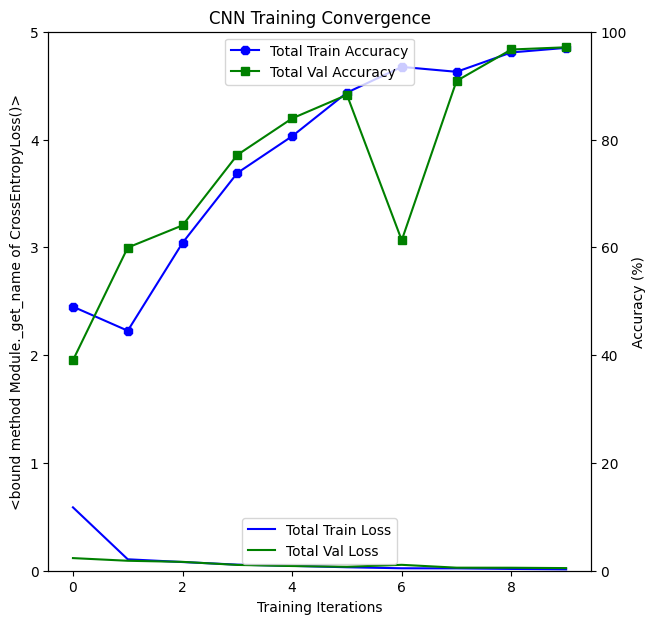

In [30]:
fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.plot(total_loss_train, "b", label="Total Train Loss")
ax1.plot(total_loss_val, "g", label="Total Val Loss")
ax1.set_ylim(0, 5)
ax1.legend(loc=8)
ax2 = ax1.twinx()
ax2.plot(total_accuracy_train, "b", marker="8", label="Total Train Accuracy")
ax2.plot(total_accuracy_val, "g", marker="s", label="Total Val Accuracy")
ax2.set_ylim(0, 100)
ax2.legend(loc=9)
plt.title("CNN Training Convergence", color="black")
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel(f"{criterion._get_name}", color="black")
ax2.set_ylabel("Accuracy (%)", color="black")
plt.show()

In [31]:
from datetime import date

today = date.today()
exec_date = today.strftime("%d%m%Y")

In [32]:
torch.save(model.state_dict(), f"./data/models/model_v1b_{exec_date}.pth")

## Testing

In [33]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [34]:
model_pred = ImageClassifier()
model_pred.load_state_dict(torch.load("checkpoint.pt"))
model_pred.to(device)

ImageClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Linear(in_features=262144, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [35]:
def test(model, loader):
    model.eval()
    total_loss_test = []
    test_probs = []
    correct_test = 0
    pred = torch.Tensor().to(device)
    with torch.no_grad():
        for batch_idx, (image, target) in tqdm(
            enumerate(loader), desc="Test Epoch", total=len(loader)
        ):
            image = image.to(device)
            target = target.to(device)
            output = model(image)
            probs = torch.sigmoid(output)
            test_probs.extend(probs.cpu().numpy())
            loss = criterion(output, target)
            total_loss_test.append(loss.item())
            test_pred = output.argmax(dim=1, keepdim=False)
            correct_test += test_pred.eq(target).sum().item()
            pred = torch.cat((pred, test_pred), 0)
        return total_loss_test, correct_test, pred, test_probs

In [36]:
total_loss_test, correct_test, y_pred, probs_pred = test(model_pred, test_loader)


Test Epoch:   0%|          | 0/17 [00:00<?, ?it/s]

## Metricas

In [37]:
print(f"Loss Test: {(sum(total_loss_test) / len(total_loss_test)):.3f}")
print(f"Test Accuracy: {(100 * correct_test/ len(test_loader.dataset)):.2f} %")

Loss Test: 0.027
Test Accuracy: 97.31 %


In [38]:
y_pred = [int(pred) for pred in y_pred.cpu().numpy().tolist()]
prob_list = [list(array) for array in probs_pred]
prob_pos = [prob_list[i][1] for i in range(len(prob_list))]

In [39]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="g")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()

# Ideas

Brenda: Merma significa "decir que la pieza es defectuosa pero en realidad esta en buen estado"

* Esto se traduce en predecir 0 (*defect confirmed by operator*) pero que en realidad sea 1 (*defect not confirmed by operator*)
* Se traduce como `Falso positivo`

0: defect confirmed by operator
1: defect not confirmed by operator

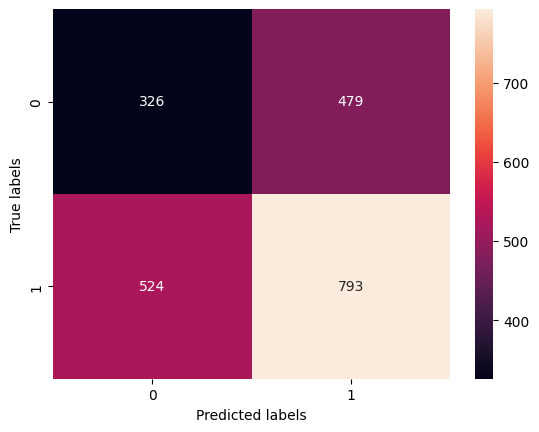

In [40]:
plot_confusion_matrix(test_dataset.targets, y_pred)


In [41]:
from sklearn.metrics import classification_report

print(
    classification_report(test_dataset.targets, y_pred)
)


              precision    recall  f1-score   support

           0       0.38      0.40      0.39       805
           1       0.62      0.60      0.61      1317

    accuracy                           0.53      2122
   macro avg       0.50      0.50      0.50      2122
weighted avg       0.53      0.53      0.53      2122



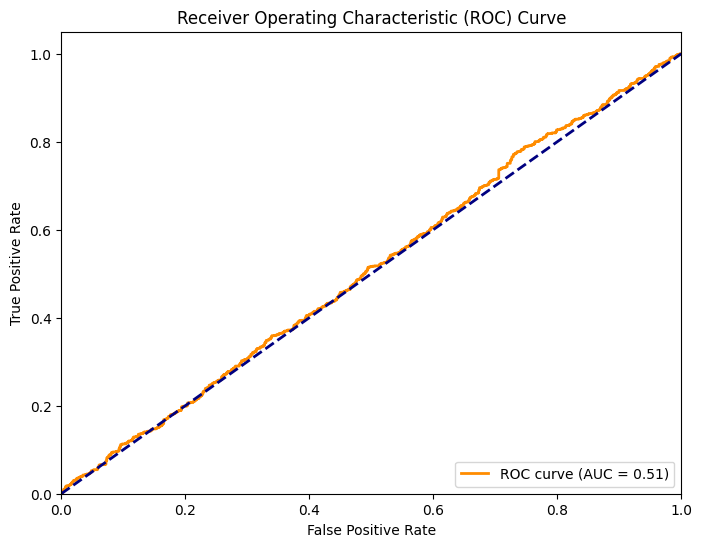

In [42]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_dataset.targets, prob_pos)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [43]:
metrics = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1",
    "ROC AUC",
    "ECE",
    "Log Loss",
    "Brier Loss",
]

perf_df = pd.DataFrame(columns=metrics)

In [44]:
def evaluate_model_performance(
    model_name, targets, predictions, prob_pos, perf_df, verbose
):
    """
    Evaluates model performance and updates the performance dataframe with metrics.
    """

    # Compute metrics
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, zero_division=0)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    roc_auc = roc_auc_score(targets, prob_pos)
    logloss = log_loss(targets, prob_pos)
    brier_loss = brier_score_loss(targets, prob_pos)

    # Compute Expected Calibration Error (ECE)
    fraction_of_positives, mean_predicted_value = calibration_curve(
        targets, prob_pos, n_bins=20, strategy="uniform"
    )
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value)) / len(
        mean_predicted_value
    )

    # Populate the performance dataframe
    perf_df.loc[model_name, :] = [
        accuracy,
        precision,
        recall,
        f1,
        roc_auc,
        ece,
        logloss,
        brier_loss,
    ]

    # Plot Calibration Curve and Histogram if verbose is True
    if verbose:
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(2, 1)
        ax_calibration_curve = fig.add_subplot(gs[0, :])
        ax_histogram = fig.add_subplot(gs[1, :])

        # Plot Calibration Curve
        ax_calibration_curve.plot(
            mean_predicted_value, fraction_of_positives, '-s', label=model_name
        )
        ax_calibration_curve.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        ax_calibration_curve.set_title(f"Calibration plot ({model_name})")
        ax_calibration_curve.set_xlabel("Mean predicted probability")
        ax_calibration_curve.set_ylabel("Fraction of positives")
        ax_calibration_curve.legend()

        # Plot Histogram
        ax_histogram.hist(
            prob_pos, range=(0, 1), bins=20, label=model_name)
        ax_histogram.set_title(f"Probability Distribution ({model_name})")
        ax_histogram.set_xlabel("Mean predicted probability")
        ax_histogram.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

    return perf_df

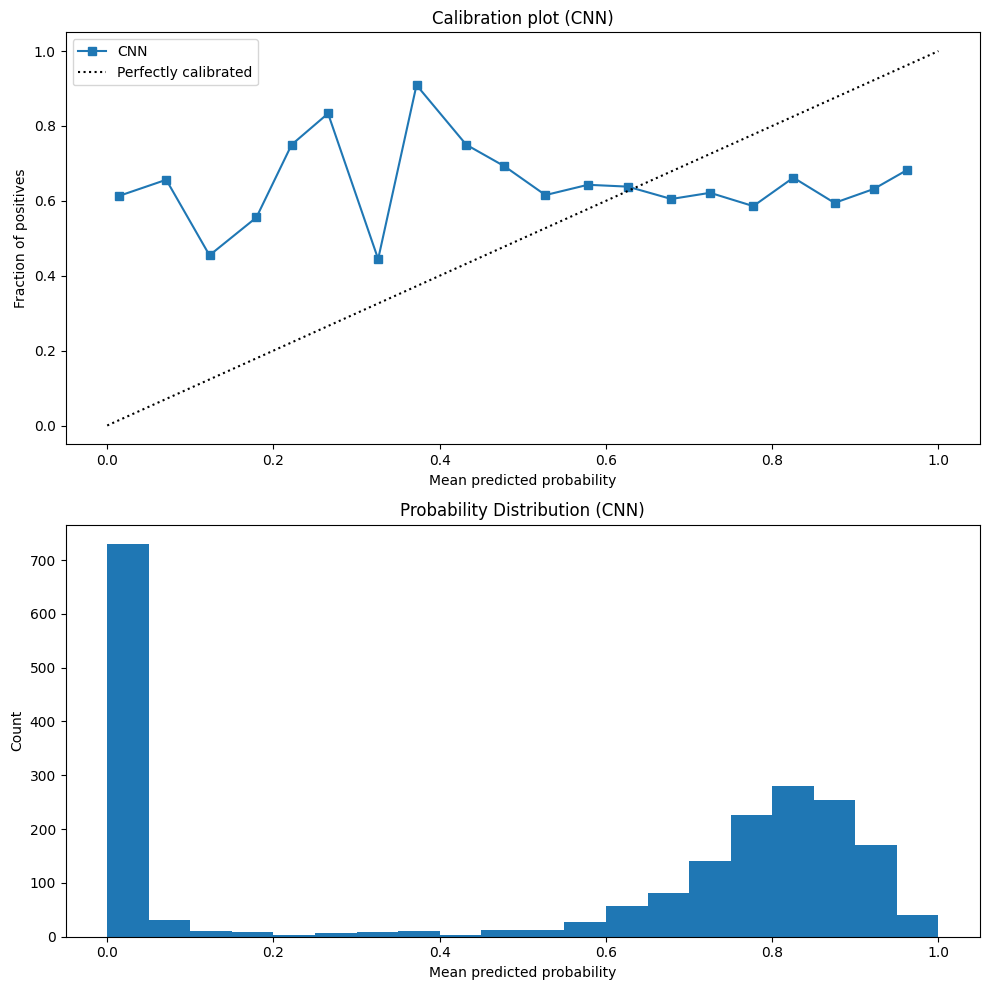

,Accuracy,Precision,Recall,F1,ROC AUC,ECE,Log Loss,Brier Loss
CNN,0.527333,0.623428,0.602126,0.612592,0.50977,0.286158,1.502015,0.392875


In [45]:
evaluate_model_performance(
    "CNN", test_dataset.targets, y_pred, prob_pos, perf_df, verbose=True
)